Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
import re
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Load Data

In [2]:
# Load data
try:
    with open('intents.json', 'r') as content:
        data = json.load(content)
except FileNotFoundError:
    print("Error: 'intents.json' file not found. Ensure it is in the correct directory.")
    raise


nltk downloading

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Text Cleaning

In [5]:
def parse_text(text):
    text = re.sub("[^a-zA-Z]", ' ', text)
    text = text.lower().split()
    stop_words = set(nltk.corpus.stopwords.words("english"))
    text = [word for word in text if word not in stop_words]
    return " ".join(text)

Data Preparation

In [6]:
# Prepare data
tags = []
inputs = []
responses = {}

# Iterate over intents
for intent in data['intents']:
    responses[intent['tag']] = intent['responses']
    for pattern in intent['patterns']:
        pattern = parse_text(pattern)
        inputs.append(pattern)
        tags.append(intent['tag'])

Convert Data to DataFrame

In [7]:
# Convert to DataFrame
data = pd.DataFrame({"patterns": inputs, "tags": tags})

Split the dataset

In [8]:
# Global settings
sentences = data['patterns']
labels = data['tags']
train_size = 0.8
EMBEDDING_DIM = 100
MAXLEN = 11
TRUNCATING = 'post'
PADDING = 'post'
unique_tags = len(data['tags'].unique())

# Split data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, labels, train_size=train_size, random_state=42)

Tokenization and Padding

In [9]:
# Tokenize
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)

# Convert to sequences and pad
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

train_padded = pad_sequences(train_sequences, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)
val_padded = pad_sequences(val_sequences, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)

Label Encoding

In [10]:
# Encode labels
label_encoder = LabelEncoder()

# Fit the LabelEncoder on all unique tags
label_encoder.fit(np.unique(tags))

# Encode train and validation labels
train_labels_encoded = label_encoder.transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

Embedding

In [11]:
# Load pre-trained GloVe embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    print("Error: 'glove.6B.100d.txt' file not found. Ensure it is in the correct directory.")
    raise

In [12]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Building the Model

In [22]:
# Model construction
def chatbot_nlp_model(vocab_size, output_length, embedding_dim, embedding_matrix, maxlen):
    model = tf.keras.Sequential([
        # Embedding Layer
        tf.keras.layers.Embedding(input_dim=vocab_size + 1,
                                  output_dim=embedding_dim,
                                  input_length=maxlen,
                                  weights=[embedding_matrix],
                                  trainable=False),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(1e-6)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(1e-6)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(output_length, activation='softmax')
    ])

    # Compile the model
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Reduced learning rate
        metrics=['accuracy']
    )
    return model

# Create and summarize the model
model = chatbot_nlp_model(vocab_size, unique_tags, EMBEDDING_DIM, embedding_matrix, MAXLEN)
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │          81,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_5                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,200 (317.19 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 81,200 (317.19 KB)

Train the model

In [23]:
# Train the model
history = model.fit(
    train_padded,
    np.array(train_labels_encoded),
    epochs=100,  # Increased epochs for better training
    batch_size=64,  # Smaller batch size for better gradient updates
    validation_data=(val_padded, np.array(val_labels_encoded)),
    verbose=1
)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 5.0304e-04 - loss: 7.4362 - val_accuracy: 0.0028 - val_loss: 7.3296
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.0064 - loss: 7.1017 - val_accuracy: 0.0101 - val_loss: 7.1424
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.0142 - loss: 6.5579 - val_accuracy: 0.0242 - val_loss: 6.3972
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.0353 - loss: 5.9060 - val_accuracy: 0.0552 - val_loss: 5.4173
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.0595 - loss: 5.2045 - val_accuracy: 0.1014 - val_loss: 4.5255
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.1064 - loss: 4.5260 - val_accuracy: 0.1797 - val_loss: 3.7954
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.1471 - loss: 3.9792 - val_accuracy: 0.2783 - val_loss: 3.1745
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.20

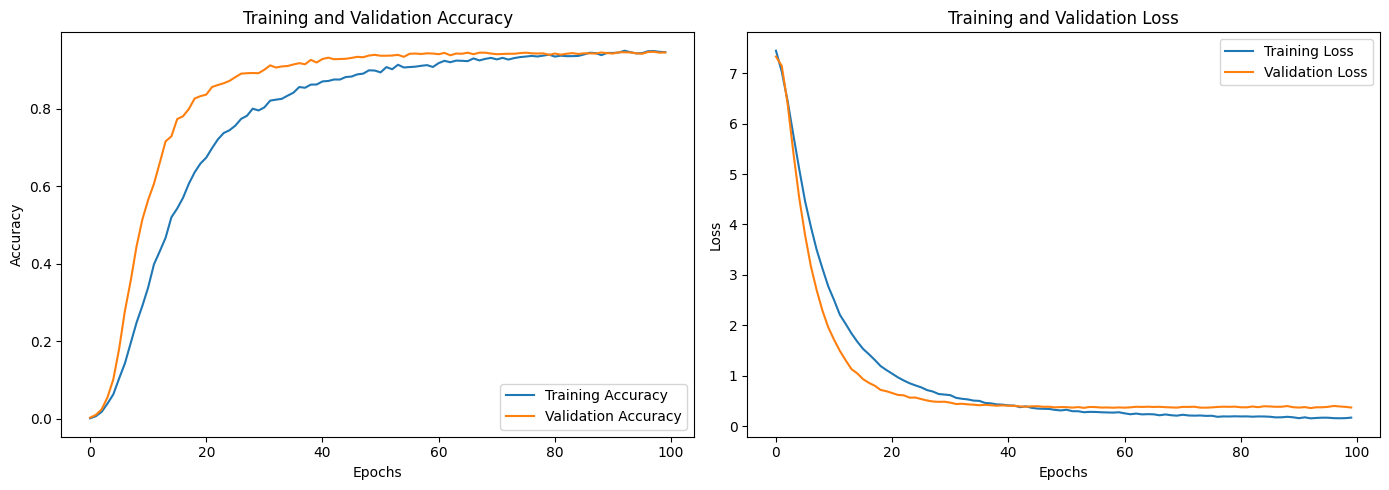

In [24]:
import matplotlib.pyplot as plt
# Function to plot training accuracy and loss
def plot_training_history(history):
    # Extract the data from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    # Plot Accuracy
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_training_history(history)


In [25]:
# Save model
model.save('chatbot_model.h5')

# Load model jika sudah disimpan sebelumnya
model = tf.keras.models.load_model('chatbot_model.h5')


In [26]:
def clean_input(text):
    text = re.sub("[^a-zA-Z]", ' ', text)
    text = text.lower().split()
    stop_words = set(nltk.corpus.stopwords.words("english"))
    text = [word for word in text if word not in stop_words]
    return " ".join(text)

def predict_response(text):
    cleaned_text = clean_input(text)
    input_sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(input_sequence, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)
    prediction = model.predict(padded_sequence)
    predicted_tag_index = np.argmax(prediction)
    predicted_tag = label_encoder.inverse_transform([predicted_tag_index])[0]
    response = np.random.choice(responses[predicted_tag])
    return response

def chat():
    print("Chatbot siap! (Ketik 'quit' untuk keluar)")

    while True:
        user_input = input("You: ")
        if user_input.lower() == "quit":
            print("Chatbot: Terima kasih! Sampai jumpa lagi!")
            break

        response = predict_response(user_input)
        print("Chatbot:", response)

# Jalankan chatbot
chat()


Chatbot siap! (Ketik 'quit' untuk keluar)
You: What should I avoid doing in Bali?
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Chatbot: In Bali, avoid touching religious offerings or idols, stepping on temple grounds without proper attire, and making loud noises during religious ceremonies.
You: Tell me about Balinese cuisine.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Chatbot: Balinese cuisine includes dishes like bebek betutu (slow-cooked duck), lawar (mixed vegetable and meat dish), and sate lilit (minced meat satay), which reflect the region's rich culinary heritage.
You: hai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Chatbot: Hi there, how can I help?
You: bye bye
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Chatbot: Sad to see you go :(
You: quit
Chatbot: Terima kasih! Sampai jumpa lagi!
